In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from kalman_experiments.kalman import Colored1DMatsudaKF, KFAdapter
from kalman_experiments.noise import ArNoise, prepare_real_noise
from kalman_experiments.models import SingleRhythmModel, ModelAdapter
from kalman_experiments.cfir import CFIRBandDetector, CFIRAdapter
from kalman_experiments.complex import complex2mat, vec2complex
from kalman_experiments.metrics import plv, env_cor

# Simulated AR noise
Parameter A in the code below corresponds to A in Matsuda's model:
$$x_{k+1} = A e^{\frac{2 \pi i f}{sr}} x_k + \nu, \nu \sim N(0, \sigma ^ 2)$$

<IPython.core.display.Javascript object>


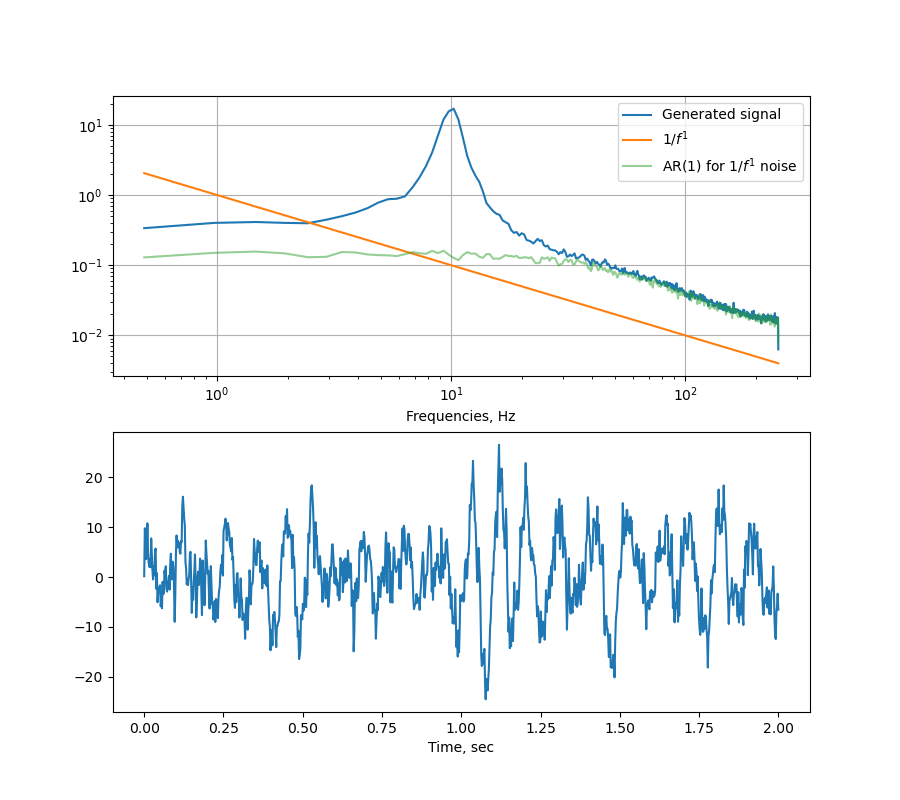

In [2]:
SRATE = 500
OSCILLATION_FREQ = 10
A = 0.99          # as in x_next = A*exp(2*pi*OSCILLATION_FREQ / sr)
SIGNAL_SIGMA = 1  # std of the model-driving white noise in the Matsuda model
NOISE_AR_ORDER = 1
ALPHA = 1
NOISE_SIGMA = 3  # std of white noise driving the ar model for the colored noise

meas_noise = ArNoise(y0=np.random.rand(NOISE_AR_ORDER), alpha=ALPHA, order=NOISE_AR_ORDER, sigma=NOISE_SIGMA)
model = SingleRhythmModel(freq=OSCILLATION_FREQ, A=A, sigma=SIGNAL_SIGMA, sr=SRATE, meas_noise=meas_noise)

n_samp = 100_000
noise_samples = np.array([meas_noise.step() for _ in range(n_samp)])
freqs, psd_noise = welch(noise_samples, fs=SRATE, nperseg=1024)
sig_samples = np.array([model.step() for _ in range(n_samp)])
freqs, psd_signal = welch(sig_samples, fs=SRATE, nperseg=1024)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))
freq_lim = 1000
ax1.loglog(freqs[1:freq_lim], psd_signal[1:freq_lim])
ax1.loglog(freqs[1:freq_lim], [1 / f**ALPHA for f in freqs[1:freq_lim]])
ax1.loglog(freqs[1:freq_lim], psd_noise[1:freq_lim], alpha=0.5)

ax1.legend([f"AR({NOISE_AR_ORDER}) for 1/f noise", "1/f", "noise"])
ax1.legend(["Generated signal", f"$1/f^{ {ALPHA} }$", f"AR({NOISE_AR_ORDER})" f" for $1/f^{ {ALPHA} }$ noise"])
ax1.set_xlabel("Frequencies, Hz")
ax1.grid()
ax2.plot(np.linspace(0, 2, 1000), sig_samples[:1000])
ax2.set_xlabel("Time, sec")

plt.show()

<IPython.core.display.Javascript object>


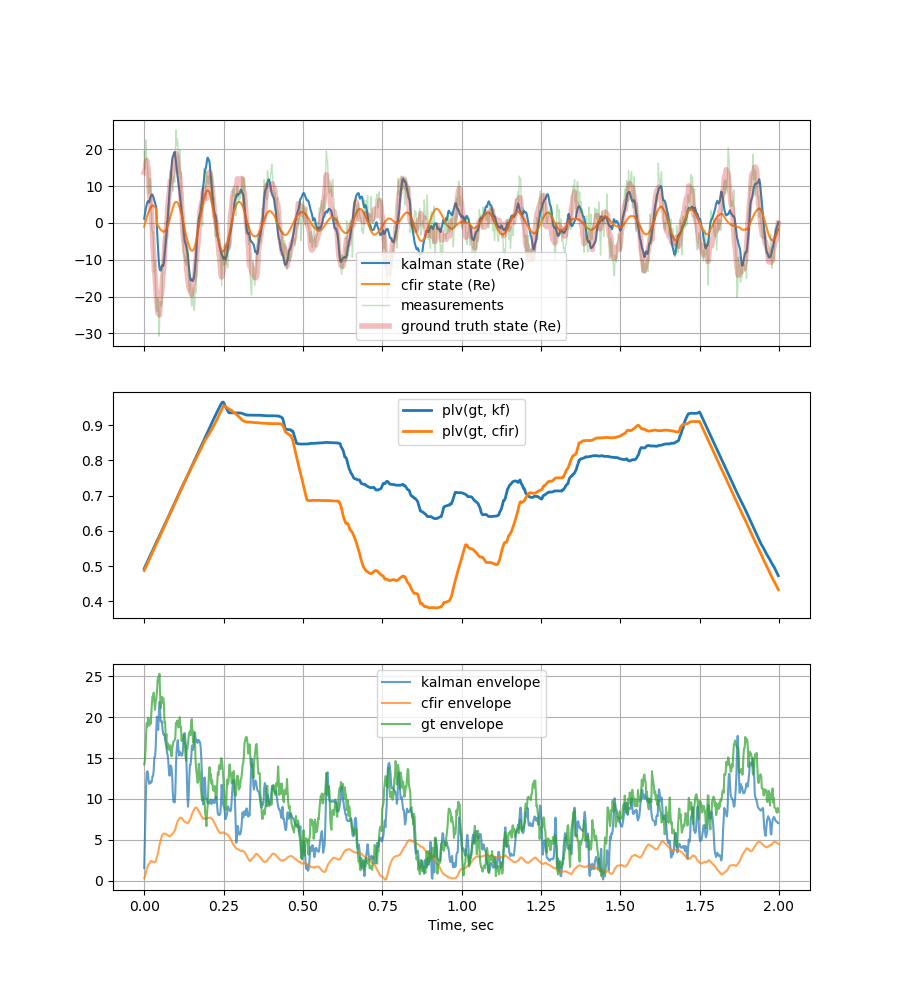

np.abs(plv_tot_kf)=0.83, np.abs(plv_tot_cfir)=0.76, envcor_kf=0.54, envcor_cfir=0.24


In [7]:
NSAMP = 1000
PSI = -0.5
DELAY = -20

gt_adapter = ModelAdapter(model)
kf = Colored1DMatsudaKF(A=A, f=OSCILLATION_FREQ, sr=SRATE, q_sigma=SIGNAL_SIGMA, psi=PSI, r_sigma=NOISE_SIGMA) 
kf_adapter = KFAdapter(kf)
cfir_adapter = CFIRAdapter([8, 12], SRATE)

gt_states, meas = gt_adapter.create_states_and_meas(NSAMP)
cfir_states = cfir_adapter.apply(meas, delay=DELAY)
kf_states = kf_adapter.apply(meas, delay=DELAY)

t = np.arange(NSAMP) / SRATE
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9, 10))
ax1.plot(t, np.roll(np.real(kf_states), shift=-DELAY), alpha=0.9)
ax1.plot(t, np.roll(np.real(cfir_states), shift=-DELAY), alpha=0.9)
ax1.plot(t, meas, alpha=0.3, linewidth=1)
ax1.plot(t, np.real(gt_states), "-", alpha=0.3, linewidth=4)
ax1.legend(["kalman state (Re)", "cfir state (Re)", "measurements", "ground truth state (Re)"])
ax1.grid()

plt.xlabel("Time, sec")
plv_win_kf, plv_tot_kf = plv(gt_states.copy(), kf_states.copy(), int(0.5 * SRATE))
plv_win_cfir, plv_tot_cfir = plv(gt_states.copy(), cfir_states.copy(), int(0.5 * SRATE))
envcor_kf = env_cor(gt_states.copy(), np.roll(kf_states.copy(), shift=-DELAY))
envcor_cfir = env_cor(gt_states.copy(), np.roll(cfir_states.copy(), shift=-DELAY))
ax2.plot(t, np.abs(plv_win_kf), linewidth=2)
ax2.plot(t, np.abs(plv_win_cfir), linewidth=2)
ax2.legend(["plv(gt, kf)", "plv(gt, cfir)"])
plt.grid()

ax3.plot(t, np.abs(kf_states), alpha=0.7)
ax3.plot(t, np.abs(cfir_states), alpha=0.7)
ax3.plot(t, np.abs(gt_states), alpha=0.7)
ax3.legend(["kalman envelope", "cfir envelope", "gt envelope"])
plt.show()
print(f"{np.abs(plv_tot_kf)=:.2f}, {np.abs(plv_tot_cfir)=:.2f}, {envcor_kf=:.2f}, {envcor_cfir=:.2f}")

# Real noise

Extracting parameters from ../data/ds004148/sub-01/ses-session2/eeg/sub-01_ses-session2_task-eyesopen_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 sec)

dm= -1.8637033749168618e-17


<IPython.core.display.Javascript object>


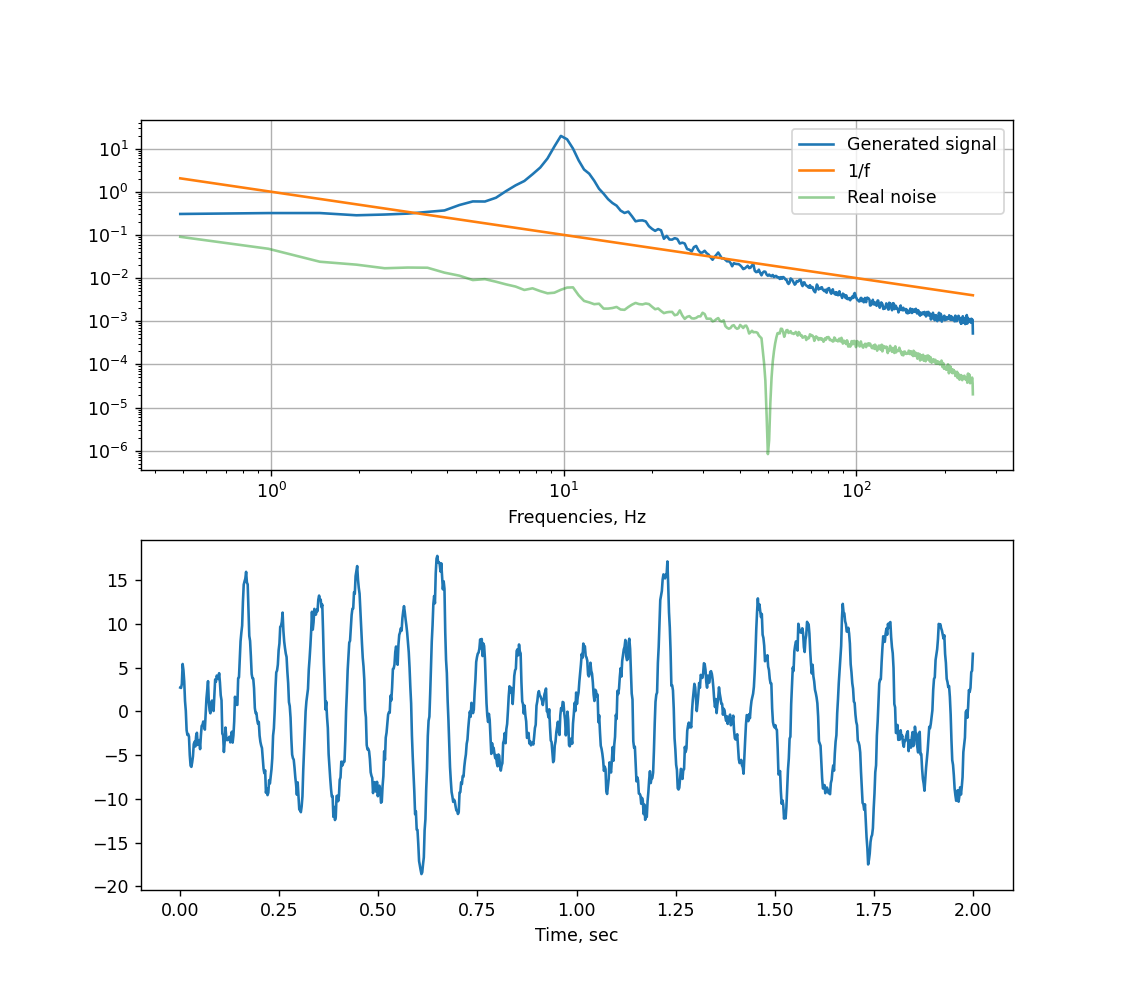

In [779]:
OSCILLATION_FREQ = 10
A = 0.99          # as in x_next = A*exp(2*pi*OSCILLATION_FREQ / sr)
SIGNAL_SIGMA = 1  # std of the model-driving white noise in the Matsuda model
NOISE_SIGMA = 1  # std of white noise driving the ar model for the colored noise
raw_path = "../data/ds004148/sub-01/ses-session2/eeg/sub-01_ses-session2_task-eyesopen_eeg.vhdr"

real_noise, srate = prepare_real_noise(raw_path=raw_path, sigma=NOISE_SIGMA)
model = SingleRhythmModel(freq=OSCILLATION_FREQ, A=A, sigma=SIGNAL_SIGMA, sr=srate, meas_noise=real_noise)

n_samp = 50_000
noise_samples = np.array([real_noise.step() for _ in range(n_samp)])
freqs, psd_noise = welch(noise_samples, fs=srate, nperseg=1024)
sig_samples = np.array([model.step() for _ in range(n_samp)])
freqs, psd_signal = welch(sig_samples, fs=srate, nperseg=1024)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))
freq_lim = 1000
ax1.loglog(freqs[1:freq_lim], psd_signal[1:freq_lim])
ax1.loglog(freqs[1:freq_lim], [1 / f for f in freqs[1:freq_lim]])
ax1.loglog(freqs[1:freq_lim], psd_noise[1:freq_lim], alpha=0.5)

ax1.legend(["Generated signal", f"1/f", "Real noise"])
ax1.set_xlabel("Frequencies, Hz")
ax1.grid()
ax2.plot(np.linspace(0, 2, 1000), sig_samples[:1000])
ax2.set_xlabel("Time, sec")

plt.show()

<IPython.core.display.Javascript object>


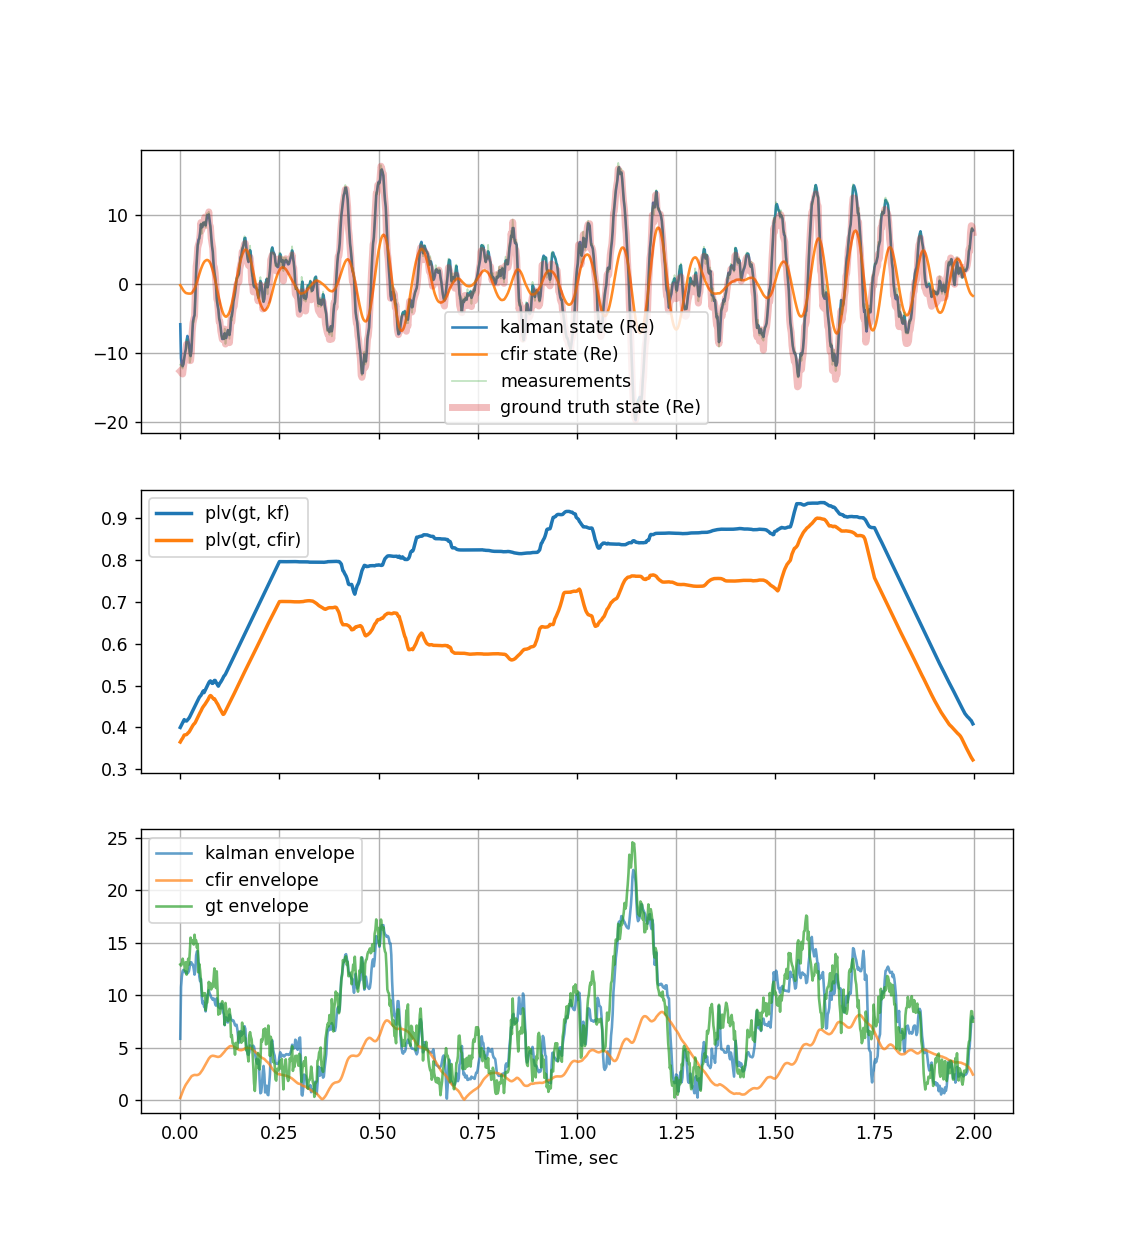

np.abs(plv_tot_kf)=0.84, np.abs(plv_tot_cfir)=0.68, envcor_tot_kf=0.90, envcor_tot_cfir=0.40


In [776]:
NSAMP = 1000
PSI = -0.5
DELAY = 0

gt_adapter = ModelAdapter(model)
kf = Colored1DMatsudaKF(A=A, f=OSCILLATION_FREQ, sr=srate, q_sigma=SIGNAL_SIGMA, psi=PSI, r_sigma=NOISE_SIGMA) 
kf_adapter = KFAdapter(kf)
cfir_adapter = CFIRAdapter([8, 12], srate)

gt_states, meas = gt_adapter.create_states_and_meas(NSAMP)
cfir_states = cfir_adapter.apply(meas, delay=DELAY)
kf_states = kf_adapter.apply(meas, delay=DELAY)

t = np.arange(NSAMP) / srate
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9, 10))
ax1.plot(t, np.roll(np.real(kf_states), shift=-DELAY), alpha=0.9)
ax1.plot(t, np.roll(np.real(cfir_states), shift=-DELAY), alpha=0.9)
ax1.plot(t, meas, alpha=0.3, linewidth=1)
ax1.plot(t, np.real(gt_states), "-", alpha=0.3, linewidth=4)
ax1.legend(["kalman state (Re)", "cfir state (Re)", "measurements", "ground truth state (Re)"])
ax1.grid()

plt.xlabel("Time, sec")
plv_win_kf, plv_tot_kf = plv(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
plv_win_cfir, plv_tot_cfir = plv(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
envcor_tot_kf = env_cor(gt_states.copy(), np.roll(kf_states.copy(), shift=-DELAY))
envcor_tot_cfir = env_cor(gt_states.copy(), np.roll(cfir_states.copy(), shift=-DELAY))
ax2.plot(t, np.abs(plv_win_kf), linewidth=2)
ax2.plot(t, np.abs(plv_win_cfir), linewidth=2)
ax2.legend(["plv(gt, kf)", "plv(gt, cfir)"])
plt.grid()

ax3.plot(t, np.roll(np.abs(kf_states), shift=0), alpha=0.7)
ax3.plot(t, np.roll(np.abs(cfir_states), shift=0), alpha=0.7)
ax3.plot(t, np.abs(gt_states), alpha=0.7)
ax3.legend(["kalman envelope", "cfir envelope", "gt envelope"])
plt.show()
print(f"{np.abs(plv_tot_kf)=:.2f}, {np.abs(plv_tot_cfir)=:.2f}, {envcor_tot_kf=:.2f}, {envcor_tot_cfir=:.2f}")

In [777]:
corrs_cfir = np.correlate(np.abs(cfir_states)[100:-99], np.abs(gt_states))
corrs_kf = np.correlate(np.abs(kf_states)[100:-99], np.abs(gt_states))
corrs_cfir /= corrs_cfir.std()
corrs_kf /= corrs_kf.std()

<IPython.core.display.Javascript object>


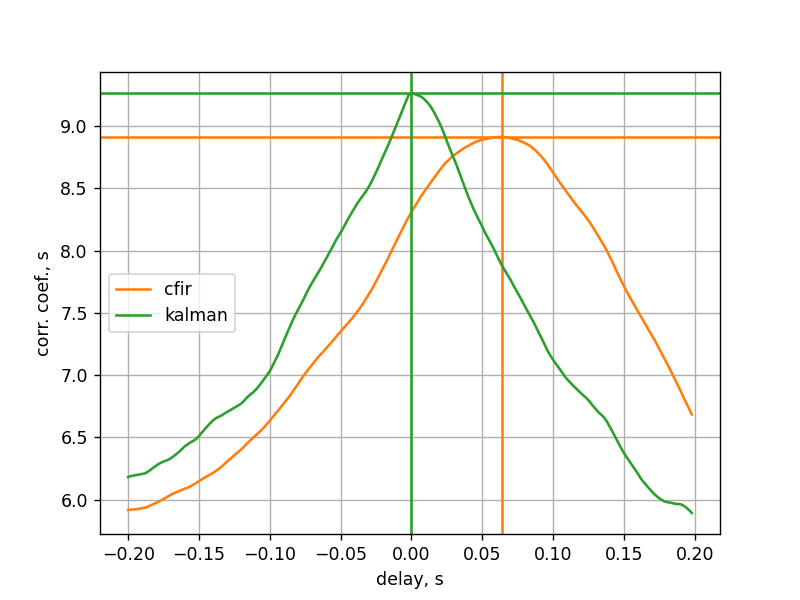

delay cfir = 64.0 ms, delay kf = 0.0 ms


In [778]:
fig = plt.figure()
ax = plt.subplot()
t = np.arange(-100, 100) / srate
ind_cfir = np.argmax(corrs_cfir)
ind_kf = np.argmax(corrs_kf)

print(f"delay cfir = {t[ind_cfir] * 1000} ms, delay kf = {t[ind_kf] * 1000} ms")

ax.plot(t, corrs_cfir, "C1", label="cfir")
ax.axvline(t[ind_cfir], color="C1")
ax.axhline(corrs_cfir[ind_cfir], color="C1")
ax.plot(t, corrs_kf, "C2", label="kalman")
ax.axvline(t[ind_kf], color="C2")
ax.axhline(corrs_kf[ind_kf], color="C2")
ax.set_xlabel("delay, s")
ax.set_ylabel("corr. coef., s")
ax.legend()
ax.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [690]:
a = np.zeros(100)
b = np.zeros(100)
a[40] = 1
b[35] = 1
cc = np.correlate(a, b[10:-29])

In [702]:
10 - cc.argmax()

-5

In [703]:
fig = plt.figure()
plt.plot(cc)

<IPython.core.display.Javascript object>